In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [2]:
num_epochs = 1000
batch_size = 32

In [3]:
df = pd.read_csv('data/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
target_column = 'quality'

y = df[target_column]
y = pd.get_dummies(y, prefix=target_column) * 1.0

x = df.drop(columns=[target_column])

In [7]:
# scale x
x = (x - x.mean()) / x.std()
x.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,3.554936e-16,1.688594e-16,-1.066481e-16,-1.110917e-16,2.132961e-16,-6.221137e-17,2.666202e-17,-3.469617e-14,2.861723e-15,6.665504e-16,7.109871e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.136377e+00,-2.277567e+00,-1.391037e+00,-1.162333e+00,-1.603443e+00,-1.422055e+00,-1.230199e+00,-3.537625e+00,-3.699244e+00,-1.935902e+00,-1.898325e+00
25%,-7.004996e-01,-7.696903e-01,-9.290275e-01,-4.530767e-01,-3.711129e-01,-8.484502e-01,-7.438076e-01,-6.075656e-01,-6.549356e-01,-6.380200e-01,-8.661079e-01
50%,-2.410190e-01,-4.367545e-02,-5.634264e-02,-2.402999e-01,-1.798892e-01,-1.792441e-01,-2.574163e-01,1.759533e-03,-7.210449e-03,-2.250577e-01,-2.092427e-01
75%,5.056370e-01,6.264921e-01,7.650078e-01,4.340257e-02,5.382858e-02,4.899619e-01,4.721707e-01,5.766445e-01,5.757422e-01,4.238832e-01,6.352984e-01
max,4.353787e+00,5.876138e+00,3.742403e+00,9.192806e+00,1.112355e+01,5.365606e+00,7.372847e+00,3.678904e+00,4.526866e+00,7.916200e+00,4.201138e+00


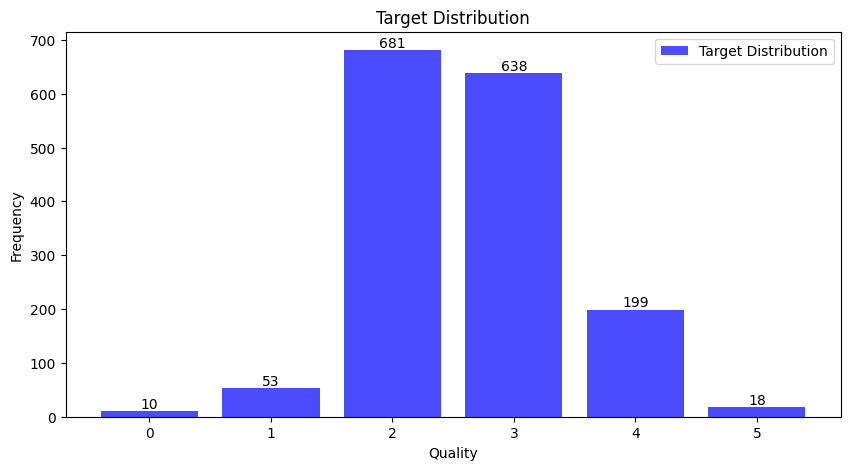

In [8]:
# plot target distribution
plt.figure(figsize=(10, 5))
frequency = y.sum(axis=0)

# add numbers on top of the bars
for i, v in enumerate(frequency.values):
    plt.text(i, v + 0.1, str(int(v)), ha="center", va="bottom")

plt.bar(
    list(range(6)),
    frequency.values,
    color="blue",
    alpha=0.7,
    label="Target Distribution",
)
plt.title("Target Distribution")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [9]:
class WineDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


train_dataset = WineDataset(x, y)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Classic NN

In [10]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 6)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        
        return x

# Initialize the MLP model
mlp_model = MLP(11, 302)
num_params = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
print(f'Number of MLP model parameters: {num_params}')

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.0005)

Number of MLP model parameters: 5442


In [11]:
# Training loop
mlp_loss_history = []
mlp_accuracy_history = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    mlp_model.train()
    mean_loss = 0
    mean_accuracy = 0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(features)
        loss = criterion(outputs.squeeze(), targets)
        mean_loss += loss.item() / targets.size(0)

        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total = targets.size(0)
        correct = (predicted == targets.argmax(axis=1)).sum().item()
        accuracy = 100 * correct / total
        mean_accuracy += accuracy

    pbar.set_postfix(
        loss=mean_loss / len(train_loader),
        accuracy=mean_accuracy / len(train_loader)
    )
    mlp_loss_history.append(mean_loss / len(train_loader))
    mlp_accuracy_history.append(mean_accuracy / len(train_loader))

100%|██████████| 1000/1000 [00:20<00:00, 47.86it/s, accuracy=98.6, loss=0.00102]


# SoftH

In [12]:
# Define the SoftHLayer
class SoftHLayer(nn.Module):
    def __init__(self, input_size, output_size, n, temperature=1.0, a=-1.0, b=1.0):
        super(SoftHLayer, self).__init__()
        self.output_size = output_size
        self.temperature = temperature

        self.values = nn.Parameter(torch.randn(output_size, input_size, n))

        # Breakpoints: linearly spaced from a to b, repeated for each feature
        breakpoints = (
            torch.linspace(a, b, n).unsqueeze(0).repeat(output_size, input_size, 1)
        )
        self.register_buffer("breakpoints", breakpoints.unsqueeze(0))

    def forward(self, x):
        # x: (batch_size, input_size)
        batch_size, input_size = x.size()

        x_expanded = x.unsqueeze(1).expand(batch_size, self.output_size, input_size)
        # x_expanded: (batch_size, output_size, input_size)
        x_expanded = x_expanded.unsqueeze(-1)
        # x_expanded: (batch_size, output_size, input_size, 1)

        distances = torch.abs(x_expanded - self.breakpoints)
        weights = F.softmax(-self.temperature * distances, dim=-1)

        # weights: (batch_size, output_size, input_size, n)
        x_out = torch.sum(weights * self.values.unsqueeze(0), dim=-1)

        # x_out: (batch_size, output_size, input_size)
        x_out = x_out.sum(-1)

        # x_out: (batch_size, output_size)
        return x_out


# Define the SoftH model
softh_model = nn.Sequential(
    SoftHLayer(11, 64, 5, temperature=1.5),
    SoftHLayer(64, 6, 5, temperature=1.5),
    nn.Softmax(dim=1),
)
num_params = sum(p.numel() for p in softh_model.parameters() if p.requires_grad)
print(f"Number of SoftH model parameters: {num_params}")

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(softh_model.parameters(), lr=0.0005)

Number of SoftH model parameters: 5440


In [13]:
# training loop
softh_history = []
softh_accuracy_history = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    softh_model.train()
    mean_loss = 0
    mean_accuracy = 0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = softh_model(features)
        loss = criterion(outputs.squeeze(), targets)
        mean_loss += loss.item() / targets.size(0)

        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total = targets.size(0)
        correct = (predicted == targets.argmax(axis=1)).sum().item()
        accuracy = 100 * correct / total
        mean_accuracy += accuracy

    pbar.set_postfix(
        loss=mean_loss / len(train_loader),
        accuracy=mean_accuracy / len(train_loader)
    )
    softh_history.append(mean_loss / len(train_loader))
    softh_accuracy_history.append(mean_accuracy / len(train_loader))

100%|██████████| 1000/1000 [01:11<00:00, 13.95it/s, accuracy=100, loss=0.000636]


# Results

In [14]:
mlp_model.eval()
softh_model.eval()

Sequential(
  (0): SoftHLayer()
  (1): SoftHLayer()
  (2): Softmax(dim=1)
)

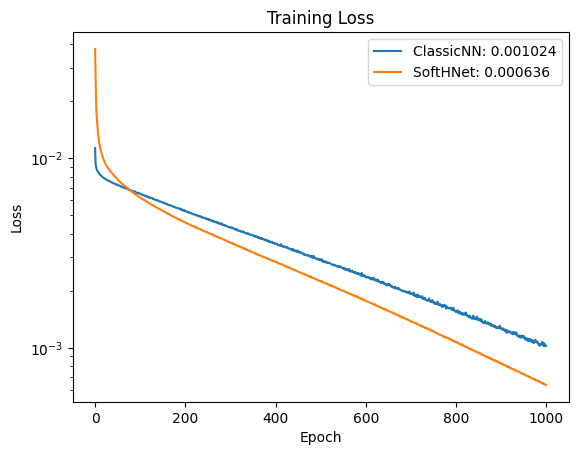

In [15]:
# plot along with the previous model
plt.plot(mlp_loss_history, label=f"ClassicNN: {mlp_loss_history[-1]:.6f}")
plt.plot(softh_history, label=f"SoftHNet: {softh_history[-1]:.6f}")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

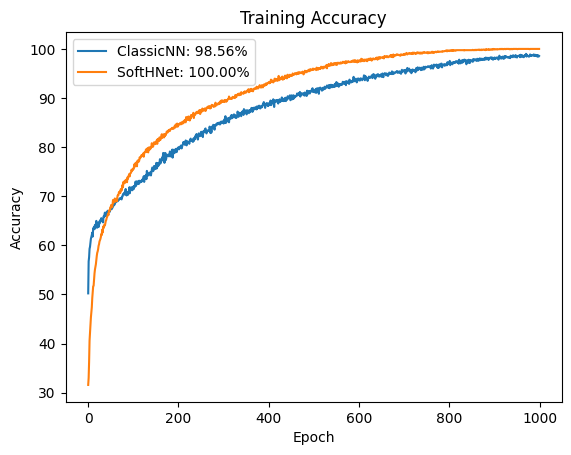

In [16]:
plt.plot(mlp_accuracy_history, label=f"ClassicNN: {mlp_accuracy_history[-1]:.2f}%")
plt.plot(softh_accuracy_history, label=f"SoftHNet: {softh_accuracy_history[-1]:.2f}%")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

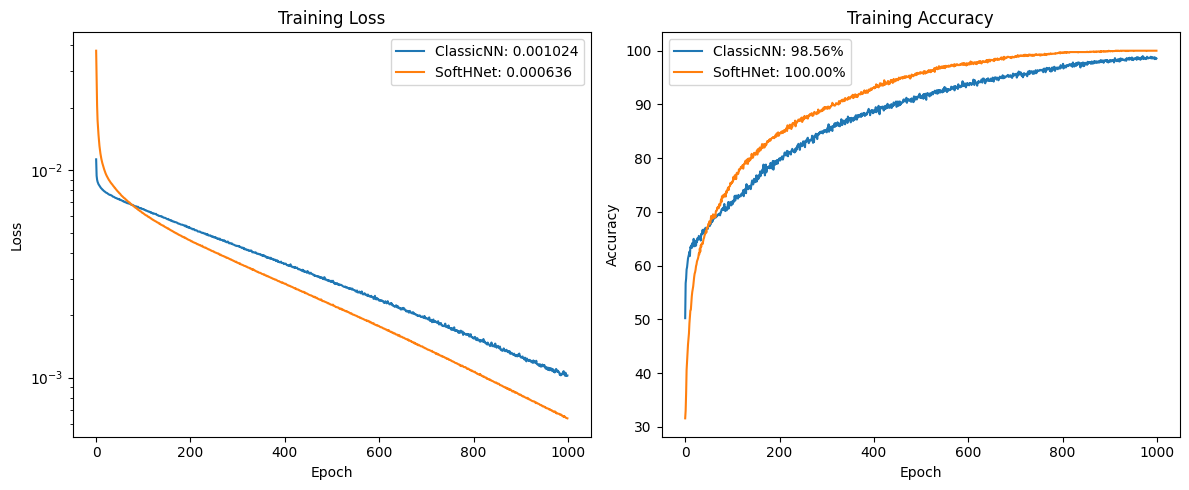

In [17]:
# plot loss and accuracy side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(mlp_loss_history, label=f"ClassicNN: {mlp_loss_history[-1]:.6f}")
ax1.plot(softh_history, label=f"SoftHNet: {softh_history[-1]:.6f}")
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_yscale("log")
ax1.legend()

ax2.plot(mlp_accuracy_history, label=f"ClassicNN: {mlp_accuracy_history[-1]:.2f}%")
ax2.plot(softh_accuracy_history, label=f"SoftHNet: {softh_accuracy_history[-1]:.2f}%")
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

In [18]:
def quadratic_weighted_kappa(y_true, y_pred, min_rating=None, max_rating=None):
    """
    Computes the Quadratic Weighted Kappa (QWK) between two rating lists.

    Args:
        y_true (list or np.array): Ground truth ratings
        y_pred (list or np.array): Predicted ratings
        min_rating (int, optional): Minimum rating (inclusive)
        max_rating (int, optional): Maximum rating (inclusive)

    Returns:
        float: QWK score between -1 and 1
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    if min_rating is None:
        min_rating = min(y_true.min(), y_pred.min())
    if max_rating is None:
        max_rating = max(y_true.max(), y_pred.max())

    # Create the confusion matrix (observed histogram)
    conf_mat = confusion_matrix(
        y_true, y_pred, labels=np.arange(min_rating, max_rating + 1)
    )

    # Normalize the observed histogram
    num_ratings = max_rating - min_rating + 1
    num_items = len(y_true)

    # Expected histogram (outer product of histograms)
    hist_true = np.bincount(y_true - min_rating, minlength=num_ratings)
    hist_pred = np.bincount(y_pred - min_rating, minlength=num_ratings)

    expected = np.outer(hist_true, hist_pred) / num_items

    # Quadratic weights matrix
    weights = np.zeros((num_ratings, num_ratings))
    for i in range(num_ratings):
        for j in range(num_ratings):
            weights[i][j] = ((i - j) ** 2) / ((num_ratings - 1) ** 2)

    # QWK calculation
    numerator = np.sum(weights * conf_mat)
    denominator = np.sum(weights * expected)

    qwk_score = 1 - numerator / denominator if denominator != 0 else 1.0

    return qwk_score, conf_mat

In [19]:
targets = y.values.argmax(axis=1)
predictions = (
    mlp_model(torch.tensor(x.values, dtype=torch.float32)).argmax(axis=1).numpy()
)
haar_predictions = (
    softh_model(torch.tensor(x.values, dtype=torch.float32)).argmax(axis=1).numpy()
)

qwk, confusion = quadratic_weighted_kappa(targets, predictions)
haar_qwk, haar_confusion = quadratic_weighted_kappa(targets, haar_predictions)
print(f"QWK: {qwk:.4f}")
print(f"SoftH QWK: {haar_qwk:.4f}")

QWK: 0.9899
SoftH QWK: 1.0000


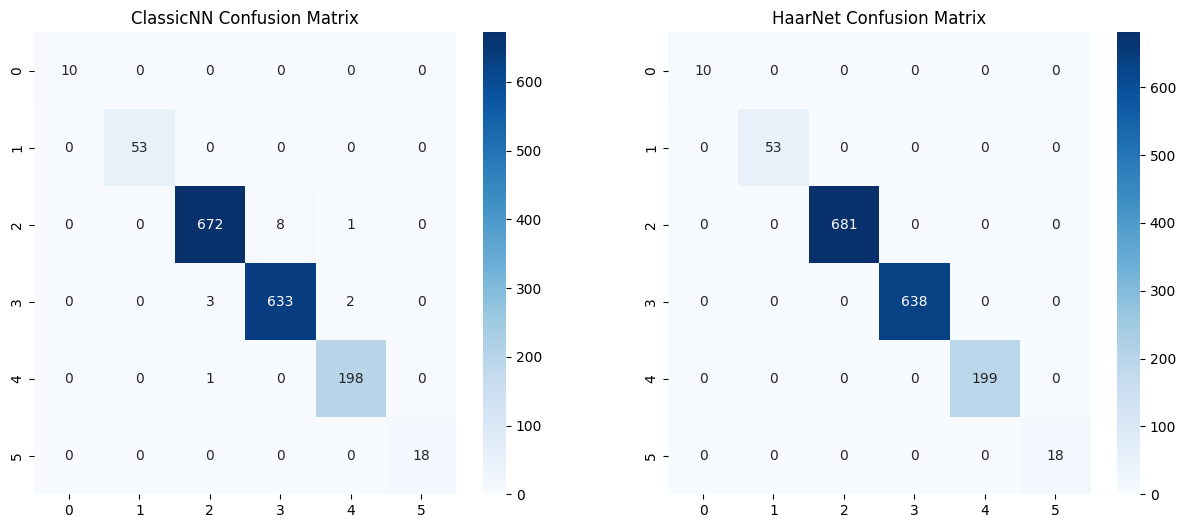

In [20]:
# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(confusion, annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title("ClassicNN Confusion Matrix")
sns.heatmap(haar_confusion, annot=True, fmt="d", ax=axes[1], cmap="Blues")
axes[1].set_title("HaarNet Confusion Matrix")
plt.show()